<a href="https://colab.research.google.com/github/VictorPelaez/demand_predictor/blob/master/electricity_sp_demand_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

import pandas as pd
import numpy as np
import urllib
import json
import datetime

# Daily Demand dataset

In [ ]:
# get data function and plot series

def get_daily_demand_data(start_date, end_date, write_json=False):
  """
    Description:
      Gets daily demand dataset from REE (spanish)
      link: https://www.ree.es/es/apidatos#request
    Input: 
      - start_date: format 'Y-m-d' as '2019-06-01'
      - end_date: 
    Output:
      - values:
      - times:
  """

  link = 'https://apidatos.ree.es/en/datos/demanda/evolucion?start_date='+start_date+'T00:00&end_date='+end_date+'T22:00&time_trunc=day'
  with urllib.request.urlopen(link) as url:
    s_raw = url.read()
    s = json.loads(s_raw)
    # print(s)

    if write_json:
      with open('data.json', 'w') as fp:
        json.dump(s, fp)

    values_dict = s['included'][0]['attributes']['values']
    values = [item['value'] for item in values_dict]
    times = [item['datetime'].split('T')[0] for item in values_dict]
    times = [datetime.datetime.strptime(t,"%Y-%m-%d").date() for t in times]
    return  np.array(values, dtype="float32"), np.array(times)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value (x1000 GWh)")
    plt.grid(True)

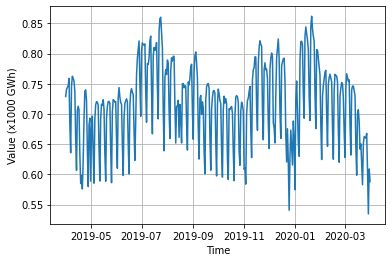

In [3]:
start_date = '2019-04-01'
end_date = '2020-03-31' 

NORM_VALUE = 1e6 # divided all values normalization

values, times = get_daily_demand_data(start_date, end_date, write_json=False)
values = values / NORM_VALUE

plot_series(times, values)

(300,) (66,)


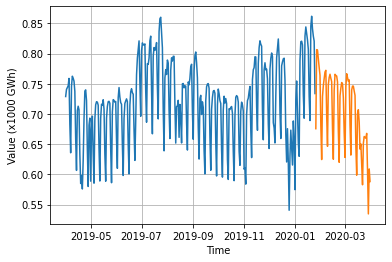

In [4]:
# split time series dataset

split_time = 300

time_train = times[:split_time]
x_train = values[:split_time]
time_valid = times[split_time:]
x_valid = values[split_time:]

plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

print(x_train.shape, x_valid.shape)


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
    Description:  
    Input: 
      - series:
      - window_size:
      - batch_size: the batches to use when training
      -shuffle_buffer: size buffer, how data will be shuffled

    Output:

  """
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # x and y (last one)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

window_size = 30
batch_size = 16
shuffle_buffer_size = 100

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

0.017690808


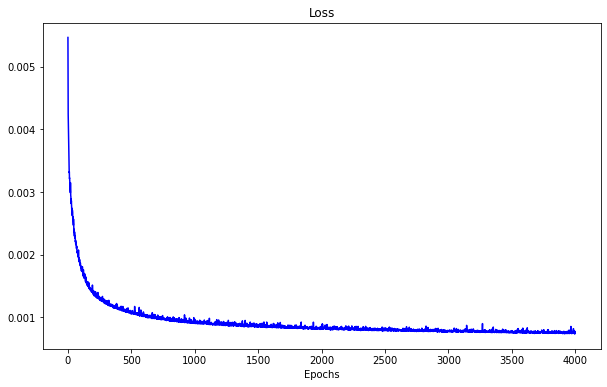

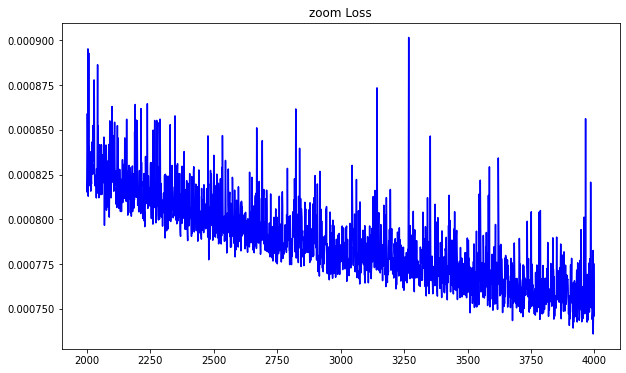

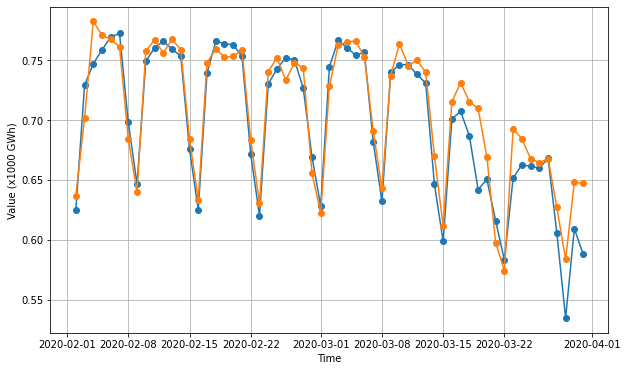

In [6]:
# Dense NN

EPOCHS = 4000
LR = 1e-3

l0 = tf.keras.layers.Dense(2*window_size+1, input_shape=[window_size], activation='relu')
l2 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([l0, l2])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3)

optimizer = tf.keras.optimizers.SGD(lr=LR, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=EPOCHS, verbose=0)

#------------------------------------------------
# Plot Loss
#------------------------------------------------
loss=history.history['loss']
epochs_=range(len(loss)) # Get number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs_, loss, 'b')
plt.title('Loss')
plt.xlabel("Epochs")

n_epochs = 2000
plt.figure(figsize=(10, 6))
plt.plot(epochs_[n_epochs:], loss[n_epochs:], 'b')
plt.title('zoom Loss')

#------------------------------------------------
# Forecasting and evaluation
#------------------------------------------------

forecast = []

for time in range(len(values) - window_size):
  forecast.append(model.predict(values[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid[7:], x_valid[7:], format='-o')
plot_series(time_valid[7:], results[7:], format='-o')

print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.011860748


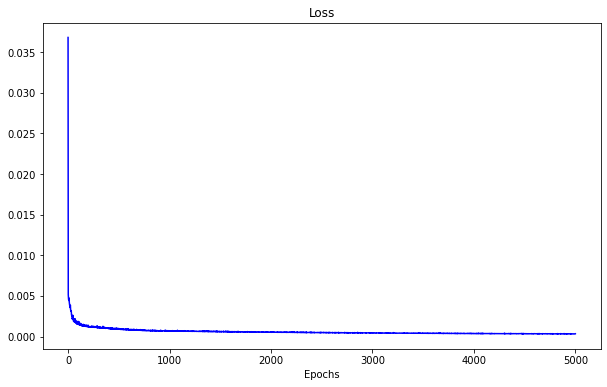

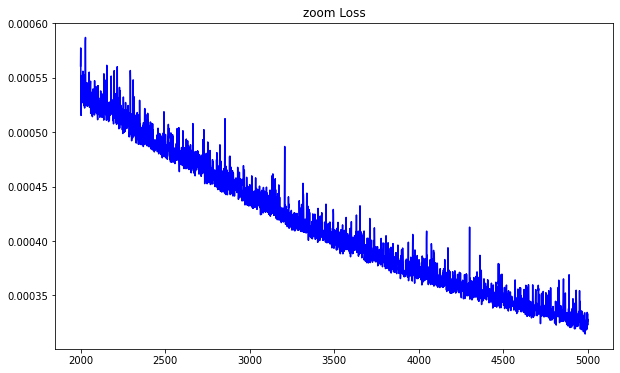

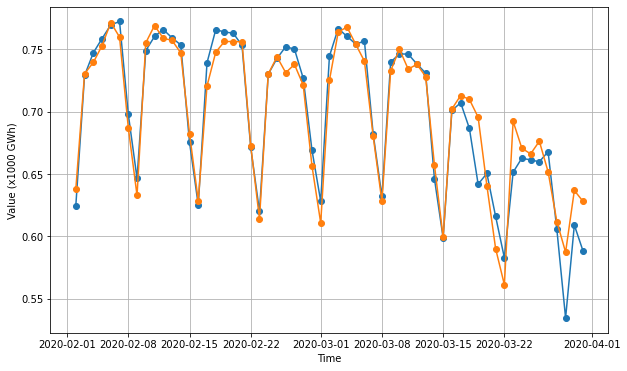

In [7]:
EPOCHS = 5000
LR = 1e-3

l0 = tf.keras.layers.Dense(2*window_size+1, activation="relu")
l1 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                    # tf.keras.layers.LSTM(units=60, return_sequences=True),
                                    tf.keras.layers.SimpleRNN(2*window_size+1, return_sequences=True),
                                    tf.keras.layers.SimpleRNN(2*window_size+1),
                                    l0,
                                    l1])

optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=EPOCHS, verbose=0)

#------------------------------------------------
# Plot Loss
#------------------------------------------------
loss=history.history['loss']
epochs_=range(len(loss)) # Get number of epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs_, loss, 'b')
plt.title('Loss')
plt.xlabel("Epochs")

n_epochs = 2000
plt.figure(figsize=(10, 6))
plt.plot(epochs_[n_epochs:], loss[n_epochs:], 'b')
plt.title('zoom Loss')

forecast = []

for time in range(len(values) - window_size):
  forecast.append(model.predict(values[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid[7:], x_valid[7:], format='-o')
plot_series(time_valid[7:], results[7:], format='-o')

print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# April days...

In [ ]:
# first days of April 

start_date = '2020-03-01'
end_date = '2020-04-05' 

NORM_VALUE = 1e6 # divided all values normalization
new_values, new_times = get_daily_demand_data(start_date, end_date)
new_values = new_values / NORM_VALUE

# with all values, times
train_set_all = windowed_dataset(values, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([l0, l2])
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set_all, epochs=4000, verbose=0)

# and forecast
n_forecast = []

for time in range(len(new_values) - window_size):
  a = model.predict(new_values[time:time + window_size][np.newaxis])
  n_forecast.append(a[0][0])

n_results = np.array(n_forecast)  

plt.figure(figsize=(10, 6))
plot_series(new_times, new_values, format='-o')
plot_series(new_times[new_times.shape[0]-len(n_forecast):], n_results, format='-o')

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(times[300:], values[300:], '-o')
plot_series(new_times, new_values, format='--')
plot_series(new_times[new_times.shape[0]-len(n_forecast):], n_results, format='-o')